In [1]:
#importing the necessary libraries
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
csv_file_path = '/content/drive/MyDrive/Projects /colab et al/tb_labels.csv'

In [3]:
#x-rays
image_dir = '/content/drive/MyDrive/Projects /colab et al/TB_CXR_images'

In [4]:
#x-ray labels
data = pd.read_csv('/content/drive/MyDrive/Projects /colab et al/tb_labels.csv')

In [5]:
data.tail()

,filename,label
130,MCUCXR_0383_1.png,1
131,MCUCXR_0387_1.png,1
132,MCUCXR_0390_1.png,1
133,MCUCXR_0393_1.png,1
134,MCUCXR_0399_1.png,1


In [6]:
#loop to extract the images and labels and add to lists
#where to store the images and the labels from the loaded data
image_paths = []
labels = []
for index, row in data.iterrows():
    filename = row['filename']
    label = row['label']

    #full path to the image
    img_path = os.path.join(image_dir, filename)

    # Check if the image file exists
    if os.path.exists(img_path):
        image_paths.append(img_path)
        labels.append(label)
print(len(labels))
print(len(image_paths))

135
135


In [7]:
# Split the data into training, validation, and test sets.
train_files, test_files, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.1, random_state=42)

In [8]:
# Display the number of samples in each set
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")
print(f"Test samples: {len(test_files)}")

Training samples: 97
Validation samples: 11
Test samples: 27


In [9]:
#Function to load and preprocess images
def load_and_preprocess_image(file_path, target_size=(224, 224)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, target_size)  # Resize the image to the target size
    img = img / 255.0  # Normalize pixel values between 0 and 1
    return img

In [10]:
# Example to load and preprocess an image
example_img = load_and_preprocess_image(train_files[0])
print(f"Example image shape: {example_img.shape}")

Example image shape: (224, 224, 3)


Correct format 224 by 224, RGB

In [11]:
# Preprocess all images in the training, validation, and test sets
X_train = np.array([load_and_preprocess_image(file) for file in train_files])
X_val = np.array([load_and_preprocess_image(file) for file in val_files])
X_test = np.array([load_and_preprocess_image(file) for file in test_files])

In [12]:
# Convert labels to np arrays
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [13]:
# We will save the preprocessed data to Drive
output_dir = '/content/drive/MyDrive/Projects/colab et al/keras01_processed_data/'
os.makedirs(output_dir, exist_ok=True)

# Save the processed data and labels as .npy files
np.save(output_dir + 'X_train.npy', X_train)
np.save(output_dir + 'X_val.npy', X_val)
np.save(output_dir + 'X_test.npy', X_test)

np.save(output_dir + 'y_train.npy', y_train)
np.save(output_dir + 'y_val.npy', y_val)
np.save(output_dir + 'y_test.npy', y_test)


In case we want to load the saved data later on.

In [14]:
"""
#To load the processed data from .npy files
output_dir = '/content/drive/MyDrive/Projects/colab et al/keras01_processed_data/'
loaded_X_train = np.load(output_dir + 'X_train.npy')
loaded_X_val = np.load(output_dir + 'X_val.npy')
loaded_X_test = np.load(output_dir + 'X_test.npy')

loaded_y_train = np.load(output_dir + 'y_train.npy')
loaded_y_val = np.load(output_dir + 'y_val.npy')
loaded_y_test = np.load(output_dir + 'y_test.npy')
"""

"\n#To load the processed data from .npy files\noutput_dir = '/content/drive/MyDrive/Projects/colab et al/keras01_processed_data/'\nloaded_X_train = np.load(output_dir + 'X_train.npy')\nloaded_X_val = np.load(output_dir + 'X_val.npy')\nloaded_X_test = np.load(output_dir + 'X_test.npy')\n\nloaded_y_train = np.load(output_dir + 'y_train.npy')\nloaded_y_val = np.load(output_dir + 'y_val.npy')\nloaded_y_test = np.load(output_dir + 'y_test.npy')\n"

Moving on to training the model after preprocessing the chest xray images

In [17]:
# importing the necessary keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [18]:
# The CNN
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3), kernel_initializer='he_normal'))  # 5x5 filters, He initialization
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (5, 5), activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(1, activation='sigmoid'))


In [19]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
# Training the model on the images
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
4/4 [==============================] - 28s 7s/step - loss: 0.0886 - accuracy: 0.9588 - val_loss: 0.8090 - val_accuracy: 0.7273
Epoch 2/10
4/4 [==============================] - 26s 6s/step - loss: 0.2601 - accuracy: 0.9485 - val_loss: 0.6973 - val_accuracy: 0.7273
Epoch 3/10
4/4 [==============================] - 26s 6s/step - loss: 0.0747 - accuracy: 0.9794 - val_loss: 0.5624 - val_accuracy: 0.7273
Epoch 4/10
4/4 [==============================] - 26s 6s/step - loss: 0.0456 - accuracy: 0.9794 - val_loss: 0.5220 - val_accuracy: 0.8182
Epoch 5/10
4/4 [==============================] - 26s 6s/step - loss: 0.0220 - accuracy: 0.9897 - val_loss: 0.5212 - val_accuracy: 0.8182
Epoch 6/10
4/4 [==============================] - 26s 6s/step - loss: 0.1499 - accuracy: 0.9794 - val_loss: 0.5323 - val_accuracy: 0.9091
Epoch 7/10
4/4 [==============================] - 25s 6s/step - loss: 0.0312 - accuracy: 0.9897 - val_loss: 0.5740 - val_accuracy: 0.9091
Epoch 8/10
4/4 [==================

In [24]:
# Evaluate model on the set aside testing data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

1/1 [==============================] - 2s 2s/step - loss: 0.8523 - accuracy: 0.7037
Test Accuracy: 0.7037037014961243


70.37% accurate. There has been some improvement compared to the last model. There were many different changes made, so the difference in output is not very explainable. For better explainability it would be better to make one change at a time and assess.

In [25]:
#saving the weights of the model
model_weights_path = '/content/drive/MyDrive/Projects/colab et al/kerastb01_model_weights.h5'
model.save_weights(model_weights_path)


In [26]:
"""
# To load later on
# Define a model with the same architecture
model = Sequential()

# ... Architecture definition goes here ...

# Load
model.load_weights('/content/drive/MyDrive/Projects/colab et al/keras_model_weights.h5')

"""

"\n# To load later on\n# Define a model with the same architecture\nmodel = Sequential()\n\n# ... Architecture definition goes here ...\n\n# Load\nmodel.load_weights('/content/drive/MyDrive/Projects/colab et al/keras_model_weights.h5')\n\n"

We can visualise this with the matplotlib library tools. 📊

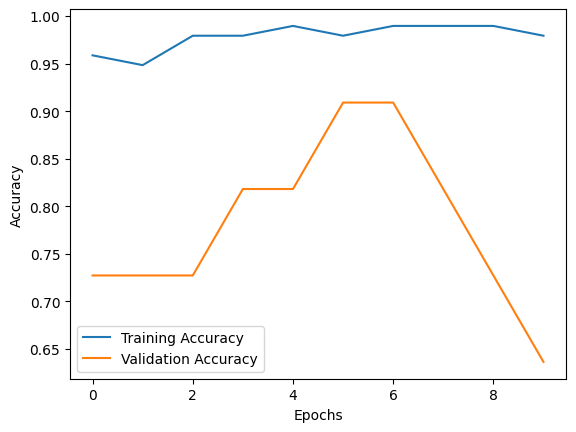

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


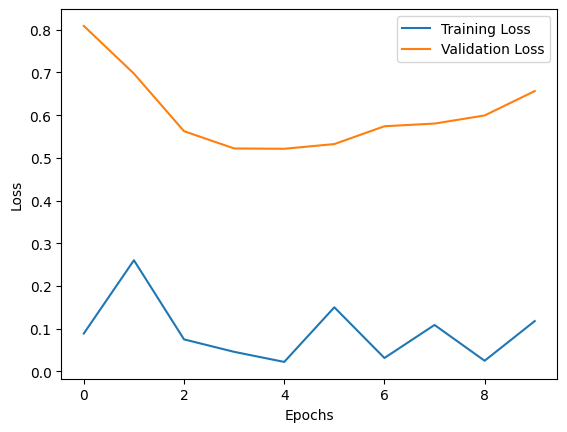

In [28]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()